## Shortest Paths and OpenStreetMap Data  
### OSM file method, direct import of PBF format

This implementation takes the following approach:
* Download OpenStreetMap data from Geofabrik, a third party OSM data provider. Data is downloaded in PBF format.
* Directly generate a NetworkX graph data structure from the PBF file using osmgraph.
* Use shortest path algorithms (a self coded version and a version already implemented in NetworkX) to find the shortest path between two nodes.

References:
* osmgraph https://github.com/Mapkin/osmgraph.
* imposm.parser (required for osmgraph) http://imposm.org/docs/imposm.parser/latest/.
* geog (alternative to haversine, which was used in other notebooks) https://github.com/jwass/geog.

Additional links to potentially extend functionality shown below:
* https://wiki.openstreetmap.org/wiki/Key:name
* https://wiki.openstreetmap.org/wiki/Nominatim
* https://geopy.readthedocs.io/en/1.11.0/

Conclusions:
* This method handles larger map areas than the Overpass API and uses a module that seems better developed. It may still be limited in the map areas is can reasonable handle; generating a graph data structure for California didn't seem to work.

In [1]:
import osmgraph
import networkx as nx
import geog
import pandas as pd
from time import time
import geopy

import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
delaware = '/Users/jason/code/msan694/osm_data/delaware-latest.osm.pbf'
G = osmgraph.parse_file(delaware)

In [4]:
G.number_of_nodes(), G.number_of_edges()

(352611, 704507)

osmgraph builds the graph object slightly differently than the get_osm_data method. Instead of strings the nodes are represented by long integers and edges include more data.

In [5]:
G.nodes(data=True)[0]

(1492123648L, {'coordinate': (-75.68069760000081, 39.39532369999987)})

In [6]:
G.edges(data=True)[0]

(1492123648L,
 1492123354L,
 {u'alt_name': u'Blackbird Midletown Road',
  u'highway': u'secondary',
  u'name': u'Summit Bridge Road',
  u'nat_name': u'Delaware Route 71',
  u'ref': u'DE 71',
  u'tiger:cfcc': u'A41',
  u'tiger:county': u'New Castle, DE',
  u'tiger:name_base': u'Summit Bridge',
  u'tiger:name_base_1': u'Blackbird Midletown',
  u'tiger:name_type': u'Rd',
  u'tiger:name_type_1': u'Rd'})

### Investigate and verify ways of calculating the distance between two points

Compare haversine module to geog module: these modules seem to be using the same formulas although one returns distances in meters and the other in kilometers.

In [5]:
# Choose two nodes on the Delaware map:
start_node = long(178641055)
end_node = long(178718777)

In [8]:
lon0 = G.node[start_node]['coordinate'][0]
lat0 = G.node[start_node]['coordinate'][1]
lon1 = G.node[end_node]['coordinate'][0]
lat1 = G.node[end_node]['coordinate'][1]

Latitude is a North-South coordinate. Positive latitude is north of the equator. Longitude is an East-West coordinate. Negative longitude is west of the Prime Meridian in Greenwich, England.

In [9]:
lon0, lat0

(-75.55755480000022, 39.744886500000156)

In [10]:
from haversine import haversine

In [11]:
# haversine points should be ordered (latitude, longitude).
haversine((lat0, lon0), (lat1, lon1), miles = False)

138.9108489766526

In [12]:
# geog.distance points should be ordered (longitude, latitude).
geog.distance((lon0, lat0), (lon1, lat1))

138910.8489766526

In [6]:
def calc_distance(node0, node1):
    # Return distance between two nodes in meters
    lat0 = node0['coordinate'][1]
    lon0 = node0['coordinate'][0]
    lat1 = node1['coordinate'][1]
    lon1 = node1['coordinate'][0]
    return geog.distance((lon0, lat0), (lon1, lat1))   

In [7]:
calc_distance(G.node[start_node], G.node[end_node])

138910.8489766526

Now pick two points in Delaware. Find the distance between them based on their coordinates and compare to the [Great Circle Mapper](http://www.gcmap.com/). According to the Great Circle Mapper the distance between airports ILG and GED is 112,086 m. There's minimal difference in the results.

In [15]:
ILG_coords = (-75.6063154, 39.6784459)
GED_coords = (-75.3602736, 38.6887426)
ILG_GED_dist = geog.distance(ILG_coords, GED_coords)
ILG_GED_dist, (ILG_GED_dist - 112086) / 112086 * 100

(112074.41621131547, -0.010334732869872815)

In [8]:
ILG_nearby_node = long(1237277400)
GED_nearby_node = long(178755464)

In [9]:
GED_nearby_node = long(2404284708)

The distance between the likely endpoint nodes is different because these nodes aren't the same as the airport node. These nodes are on nearby roads. These nodes should be used for example shortest path calculations for the Delaware example.

In [6]:
calc_distance(G.node[ILG_nearby_node], G.node[GED_nearby_node])

45.295286355447942

### Assign edge weights
Iterate through the edges in the graph and assign weights.

In [10]:
for node0, node1 in G.edges_iter():
    G[node0][node1]['distance'] = calc_distance(G.node[node0], G.node[node1])

### Export edge list to CSV (for processing in Spark or Hive)

In [18]:
def process_edgelist(edge):
    return (edge[0], edge[1], edge[2]['distance'])
edgelist = map(process_edgelist, nx.to_edgelist(G))
edgelist_df = pd.DataFrame.from_records(edgelist, columns=['node0', 'node1', 'distance'])
edgelist_df.to_csv('edgelist.csv.gz', header=False, index=False, compression='gzip')

### Calculate a shortest path with Dijkstra's algorithm, NetworkX implementation
[Reference path](https://www.openstreetmap.org/directions?engine=osrm_car&route=39.6780%2C-75.6060%3B38.6890%2C-75.3600#map=9/39.1908/-75.5214) from OpenStreetMap.

In [20]:
t0 = time()
path_length = nx.dijkstra_path_length(G, ILG_nearby_node, GED_nearby_node, weight='distance')
print path_length, time() - t0

61.8099282111 1.79909491539


In [54]:
t0 = time()
path = nx.dijkstra_path(G, ILG_nearby_node, GED_nearby_node, weight='distance')
print len(path), time() - t0

6 0.000216960906982


In [22]:
ends = (ILG_nearby_node, GED_nearby_node)

In [35]:
def node_coords(G, node):
    lat = G.node[node]['coordinate'][1]
    lon = G.node[node]['coordinate'][0]
    return {'lat': lat, 'lon':lon}

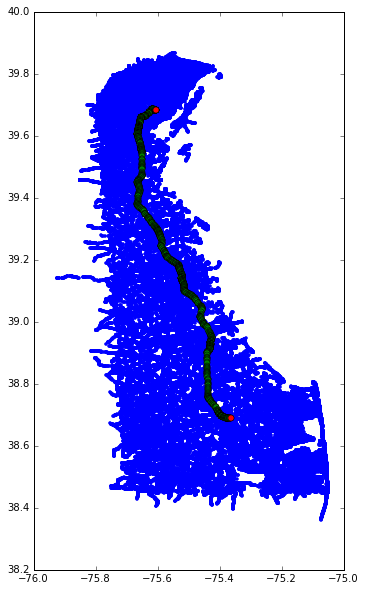

In [36]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.plot([node_coords(G, n)['lon'] for n in G], [node_coords(G, n)['lat'] for n in G], '.')
ax.plot([node_coords(G, n)['lon'] for n in path], [node_coords(G, n)['lat'] for n in path], 'o')
ax.plot([node_coords(G, n)['lon'] for n in ends], [node_coords(G, n)['lat'] for n in ends], 'o')
ax.set_aspect(aspect='equal')

### Calculate a shortest path with Dijkstra's algorithm, self coded implementation
This method uses Dijkstra's algorithm, as described by [Wikipedia](https://en.wikipedia.org/wiki/Dijkstra%27s_algorithm), to calculate the same path as in the previous NetworkX method. The code also incorporates suggestions for how to implement a priority queue in Python using the [heapq module](https://docs.python.org/2/library/heapq.html#priority-queue-implementation-notes).

In [11]:
from itertools import count
from heapq import heappush, heappop

In [30]:
def dijkstra(G, source, target=None, weight="distance"):
    """ Calculate all shortest paths from a given source node using Dijkstra's algorithm.
    
    Args:
        G: a NetworkX graph object
        source: the starting node for the shortest path algorithm
        
    Returns: a tuple holding two dictionaries. The first indicates the length of the 
        shortest path to every node in G. The second indicates the previous node for
        any given node along the shortest path.
    
    """
    push = heappush
    pop = heappop
    
    dist = dict()
    prev = dict()
    q = []
    inf = float("inf")
    c = count()
    
    for v in G.nodes_iter():
        dist[v] = inf
        prev[v] = None
        push(q, (inf, next(c), v))
    
    push(q, (0, next(c), source))
    dist[source] = 0
    visited = set()
    visited_list = []
    
    while q:
        d, _, u = pop(q)
        if u in visited:
            continue
        #if u == target:
        #    break;
        visited.add(u)
        visited_list.append(u)
        #print "visiting", u
        #for v in G[u]:
        for v in G.successors(u):
            alt = dist[u] + G.get_edge_data(u, v)[weight]
            #print "cur dist to ", v, " is ", dist[v]
            #print "new dist to ", v, " is ", alt
            if alt < dist[v]:
                #print "updating distance"
                dist[v] = alt
                prev[v] = u
                push(q, (alt, next(c), v))
    return dist, prev, visited_list 

In [31]:
t0 = time()
dist, prev, vis = dijkstra(G, ILG_nearby_node, GED_nearby_node)
print dist[GED_nearby_node], time() - t0

61.8099282111 3.84344506264


The actual path isn't immediately recoverable without an additional function, but the distances are exactly equal, suggesting the paths found with the two algorithms are identical.

In [41]:
ILG_nearby_node, GED_nearby_node

(1237277400L, 2404284708L)

In [11]:
def find_shortest_path(prev_dict, target):
    """Find the shortest path given a dictionary of previous nodes. Note that the source node is
    a fixed property of one of the arguments to this function.
    
    Args:
        prev_dict: a dictionary of nodes. The values are the previous node on the shortest path
        to a fixed source node.
        target: the desired end point.
        
    Returns:
        The shortest path between the source and target nodes.
    """
    path = [target]
    prev = prev_dict[target]
    while prev:
        path.append(prev)
        prev = prev_dict[prev]
    path.reverse() 
    return path

### Compare the path found by the self coded method to that found with NetworkX

In [12]:
find_shortest_path(prev, GED_nearby_node)

[1237277400L, 1237278781L, 1237278824L, 2404284705L, 2404284707L, 2404284708L]

In [63]:
# path is the variable defined previously. It holds the shortest path using the NetworkX Dijkstra implementation.
path

[1237277400L, 1237278781L, 1237278824L, 2404284705L, 2404284707L, 2404284708L]

In [14]:
vis.index(GED_nearby_node)

11

In [ ]:
1237277400, 0)
(1237278813, 3.54057539182)
(1237278781, 9.61416387992)
(1237278051, 10.37792164917)
(2404284703, 15.22709910557)
(1237277072, 19.7599136515)
(1237278824, 21.686353484919998)
(2404284705, 23.193186384769998)
(1237278875, 25.75168986588)
(2404284707, 30.639559839199997)
(1237278157, 32.36809645706)

In [17]:
vis[:12]

[1237277400L,
 1237278813L,
 1237278781L,
 1237278051L,
 2404284703L,
 1237277072L,
 1237278824L,
 2404284705L,
 1237278875L,
 2404284707L,
 1237278157L,
 2404284708L]

In [18]:
G[long(1237278157)]

{1237278875L: {'distance': 6.6164065911787278, u'highway': u'service'}}

In [26]:
len(vis)

11

### Test reverse geocoding using geopy
This code represents future work to test a package to find the closest matching OSM node to a provided address.

In [42]:
from geopy.geocoders import Nominatim
geolocator = Nominatim()
location = geolocator.geocode("ILG airport")
print(location.address)
print((location.latitude, location.longitude))
print(location.raw)

New Castle County Airport, South Hollow Road, Manor Park, New Castle County, Delaware, 19720, United States of America
(39.6784459, -75.6063155)
{u'display_name': u'New Castle County Airport, South Hollow Road, Manor Park, New Castle County, Delaware, 19720, United States of America', u'importance': 0.390701435537, u'place_id': u'3270706', u'lon': u'-75.6063155', u'lat': u'39.6784459', u'osm_type': u'node', u'licence': u'Data \xa9 OpenStreetMap contributors, ODbL 1.0. http://www.openstreetmap.org/copyright', u'osm_id': u'368381231', u'boundingbox': [u'39.6634459', u'39.6934459', u'-75.6213155', u'-75.5913155'], u'type': u'aerodrome', u'class': u'aeroway', u'icon': u'https://nominatim.openstreetmap.org/images/mapicons/transport_airport2.p.20.png'}
